Using abcTau to fit ACFs for trials (Figure 2 from the paper). 

Three options to do that:
* use abcTau package for both ACF and fitting
* use ACF calculated before using acf function
* use ACF calculated before using iSTTC concat function

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns 

import pickle
import numpy as np
import pandas as pd
from scipy import stats

# add the path to the abcTau package
import sys
#sys.path.append('./abcTau')
sys.path.append('C:\\Users\\ipochino\\AppData\\Local\\anaconda3\\envs\\isttc\\Lib\\site-packages\\abcTau') # IP: replaced previous line with that; relative path was not working
import abcTau

from isttc.scripts.cfg_global import project_folder_path

In [44]:
dataset_folder = project_folder_path + 'synthetic_dataset\\'
results_folder = project_folder_path + 'results\\synthetic\\results\\param_fr_alpha_tau\\'
results_folder_abctau = project_folder_path + 'results\\synthetic\\results\\param_fr_alpha_tau_abctau\\acf_comp\\'
fig_folder = results_folder_abctau

save_fig = True

### Load data (spike trains and calculated acf's)

In [3]:
with open(dataset_folder + 'trials40_binned.pkl','rb') as f:
    data_binned = pickle.load(f)

trial_dict_binned = data_binned['trial_dict']
alphas_binned  = data_binned['alphas']
fr_values_binned  = data_binned['fr_values']
taus_ms_binned  = data_binned['tau_ms']
n_trials_binned  = data_binned['n_trials']
trial_lens_binned  = data_binned['trial_lens']

print(f'n spike trains {len(trial_dict_binned)}, trial_lens {trial_lens_binned[0]} ms')

n spike trains 100000, trial_lens 1000 ms


In [4]:
with open(results_folder + 'tau_pearsonr_trial_50ms_20lags_dict.pkl', "rb") as f:
    pearsonr_trial_avg_dict = pickle.load(f)

with open(results_folder + 'tau_isttc_trial_concat_50ms_20lags_dict.pkl', "rb") as f:
    sttc_trial_concat_dict = pickle.load(f)

with open(results_folder + 'tau_isttc_full_50ms_20lags_dict.pkl', "rb") as f:
    isttc_full_dict = pickle.load(f)

with open(results_folder + 'tau_acf_full_50ms_20lags_dict.pkl', "rb") as f:
    acf_full_dict = pickle.load(f)

print(f'len pearsonr_trial_avg_dict {len(pearsonr_trial_avg_dict)}')
print(f'len sttc_trial_concat_dict {len(sttc_trial_concat_dict)}')
print(f'len isttc_full_dict {len(isttc_full_dict)}')
print(f'len acf_full_dict {len(acf_full_dict)}')

len pearsonr_trial_avg_dict 100000
len sttc_trial_concat_dict 100000
len isttc_full_dict 100000
len acf_full_dict 100000


### Calculate ACF using methods from abcTau 

In [5]:
# data parameters
summStat_metric = 'comp_cc'
summStat_metric_fft ='comp_ac_fft'
ifNorm = True # if normalize the autocorrelation or PSD
deltaT = 1 # temporal resolution of data.
binSize = 50 #  bin-size for binning data and computing the autocorrelation.
maxTimeLag = 1000 # only used when using autocorrelation for summary statistics

In [6]:
data_sumStat_l = []
data_sumStat_fft_l = []
unit_id_l = []

for k,v in list(trial_dict_binned.items()):
    if k % 5000 == 0:
        print(f'Processing {k}....')
    spike_binned = v[0]
    numTrials = n_trials_binned[k]
    T = trial_lens_binned[k]
    numBinData = spike_binned.shape[1]
    
    data_sumStat = abcTau.summary_stats.comp_sumStat(spike_binned, summStat_metric, ifNorm, deltaT, binSize, T, numBinData, maxTimeLag)
    data_sumStat_fft = abcTau.summary_stats.comp_sumStat(spike_binned, summStat_metric_fft, ifNorm, deltaT, binSize, T, numBinData, maxTimeLag)
    
    data_sumStat_l.append(data_sumStat)
    data_sumStat_fft_l.append(data_sumStat_fft)
    unit_id_l.append(k)

Processing 0....


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\abcTau\summary_stats.py:44: RuntimeWarning: invalid value encountered in divide
  sumStat = sumStat/sumStat[0]
C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\abcTau\summary_stats.py:52: RuntimeWarning: invalid value encountered in divide
  sumStat = sumStat/sumStat[0]


Processing 5000....
Processing 10000....
Processing 15000....
Processing 20000....
Processing 25000....
Processing 30000....
Processing 35000....
Processing 40000....
Processing 45000....
Processing 50000....
Processing 55000....
Processing 60000....
Processing 65000....
Processing 70000....
Processing 75000....
Processing 80000....
Processing 85000....
Processing 90000....
Processing 95000....


In [16]:
# save dict with acfs
abctau_acf_dict = {
    unit_id: {'acf_cc': acf, 'acf_fft': fft}
    for unit_id, acf, fft in zip(unit_id_l, data_sumStat_l, data_sumStat_fft_l)
}
with open(results_folder_abctau + 'acfs_abctau_dict.pkl', "wb") as f:
    pickle.dump(abctau_acf_dict, f)

In [26]:
rows = []

for unit_id in unit_id_l:
    methods = {
        'abctau_cc': abctau_acf_dict[unit_id]['acf_cc'][:-1],
        'abctau_fft': abctau_acf_dict[unit_id]['acf_fft'],  # len 19
        'pearsonr': pearsonr_trial_avg_dict[unit_id]['acf'][0][:-1],
        'sttc_concat': sttc_trial_concat_dict[unit_id]['acf'][0][:-1],
        'acf': acf_full_dict[unit_id]['acf'][:-2],
    }

    ref = np.asarray(isttc_full_dict[unit_id]['acf'][:-2])

    for name, y in methods.items():
        # truncate arrays to same length 
        n = min(len(ref), len(y))
        corr = np.corrcoef(ref[:n], y[:n])[0, 1]
        rmse = np.sqrt(np.mean((ref[:n] - y[:n]) ** 2))
        rows.append({
            'unit_id': unit_id,
            'method': name,
            'corr': corr,
            'rmse': rmse
        })

metrics_df = pd.DataFrame(rows)
metrics_df.to_pickle(results_folder_abctau + 'metrics_df.pkl')

C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [25]:
df[df['unit_id'] == 1100]

,unit_id,method,corr,rmse
5500,1100,abctau_cc,NaN,NaN
5501,1100,abctau_fft,NaN,NaN
5502,1100,pearsonr,NaN,NaN
5503,1100,sttc_concat,NaN,0.383154
5504,1100,acf,0.978019,0.088239


### Plot

In [31]:
color_acf_full = '#718190'
color_isttc_full = '#1ba9e2' 
color_pearson_trail_avg = '#f4a91c' 
color_sttc_trail_concat = '#955da2' 

color_abctau_cc = '#B4464B'
color_abctau_fft = '#A74C55'

colors = [color_acf_full, color_pearson_trail_avg, color_sttc_trail_concat, color_abctau_cc, color_abctau_fft]

In [32]:
df_clean = metrics_df.dropna(subset=['corr', 'rmse'])
counts = df_clean.groupby('unit_id')['method'].nunique()
valid_ids = counts[counts == 5].index
metrics_df_filtered = df_clean[df_clean['unit_id'].isin(valid_ids)].copy()

metrics_df_filtered.reset_index(inplace=True, drop=True)
metrics_df_filtered

,unit_id,method,corr,rmse
0,0,abctau_cc,0.908405,0.157739
1,0,abctau_fft,0.911548,0.269434
2,0,pearsonr,0.984191,0.047128
3,0,sttc_concat,0.988168,0.045482
4,0,acf,0.998985,0.021517
...,...,...,...,...
455610,99999,abctau_cc,0.963280,0.070324
455611,99999,abctau_fft,0.947336,0.111390
455612,99999,pearsonr,0.968888,0.056118
455613,99999,sttc_concat,0.976927,0.049002


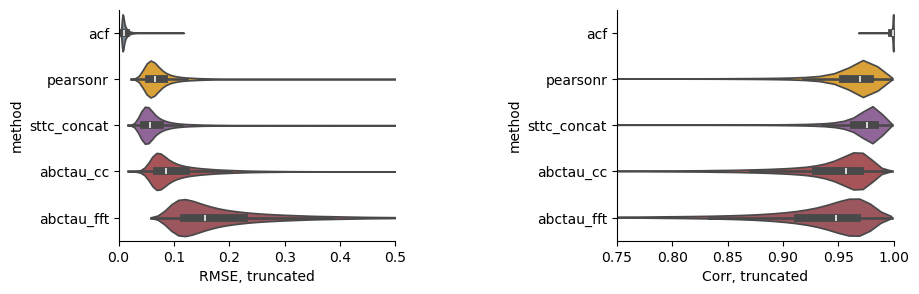

In [46]:
fig, axes = plt.subplots(1,2, figsize=(10,3))
plt.subplots_adjust(hspace=0.4, wspace=0.8)

method_order = ['acf', 'pearsonr', 'sttc_concat', 'abctau_cc', 'abctau_fft']
sns.violinplot(y='method', x='rmse', hue='method', order=method_order, hue_order=method_order, 
               palette=colors, data=metrics_df_filtered , cut=0, ax=axes[0])
axes[0].set_xlabel('RMSE, truncated')
axes[0].set_xlim([0, 0.5])

sns.violinplot(y='method', x='corr', hue='method', order=method_order, hue_order=method_order, 
               palette=colors, data=metrics_df_filtered , cut=0, ax=axes[1])
axes[1].set_xlabel('Corr, truncated')
axes[1].set_xlim([0.75, 1])

for ax in axes.flat:
    sns.despine(ax=ax)

if save_fig:
    plt.savefig(fig_folder + 'corr_rmse_acfs.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'corr_rmse_acfs.svg' , bbox_inches='tight')

In [48]:
for unit_id in range(100):

    fig, axes = plt.subplots(1,1)
    
    axes.plot(abctau_acf_dict[unit_id]['acf_cc'], color=color_abctau_cc, label='abctau_cc')
    axes.plot(pearsonr_trial_avg_dict[unit_id]['acf'][0], color=color_pearson_trail_avg, label='pearsonr')
    axes.plot(sttc_trial_concat_dict[unit_id]['acf'][0], color=color_sttc_trail_concat, label='sttc_concat')
    axes.plot(acf_full_dict[unit_id]['acf'], color=color_acf_full, label='acf')
    axes.plot(isttc_full_dict[unit_id]['acf'], color=color_isttc_full, label='isttc')
    
    axes.axhline(y=0, lw=0.5, c='k')
    
    axes.legend(frameon=False)
    
    sns.despine()

    # save without showing
    fig.savefig(fig_folder + f"acf_plot_unit_{unit_id}.png", dpi=300, bbox_inches='tight')
    plt.close(fig)  